# 📦 Updating a reference model with a plus-one dataset

This vignette introduces a lightweight strategy to update an existing reference classifier by adding one new dataset—referred to here as a **plus-one update.**
This approach provides a practical way to expand a reference model incrementally as new datasets become available.

The overall goal is simple: improve coverage of specific tissues or conditions **without rebuilding the entire atlas from scratch.**

In [22]:
import pandas as pd
import numpy as np
import celltypist
import scanpy as sc

from tqdm import tqdm
from glob import glob
import random
random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt

celltypist.logger.set_level(50)

import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# functions for loading pangea model
import pickle as pkl

def pklrd(filename):
    with open(filename, "rb") as file:
        data = pkl.load(file)
        return data

def pklwr(data, filename):
    with open(filename, "wb") as file:
        pkl.dump(data, file)

## Load the new ("plus-one") dataset

We first load the new dataset that we want to incorporate into the existing reference model.

In [21]:
xdata = sc.read('/nfs5/SCMGL/srk06_DBH/994_revision/06_plusone_noGPU/outs_base/Craig-Schapiro_2025_Pancreas/adata_postprocessing_islet_bbknn_withlabels.h5ad')

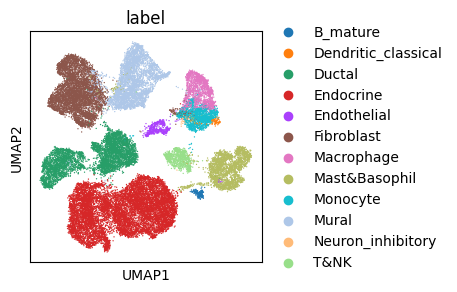

In [42]:
sc.pl.umap(xdata, color = 'label', show = False)
plt.gcf().set_size_inches(3,3)

The dataset contains various pancreatic cell types.
To avoid over-representing large clusters during training, we subsample below.

## Subsample for class balance

Large clusters can bias a logistic regression classifier.  
To minimize imbalance, we downsample each label to a maximum number of cells:

In [44]:
## setting maximum cell count for updating
Nmax = 500 

In [45]:
labels = xdata.obs.value_counts("label").index.to_list()

In [46]:
idxls = []
for label in labels:
    tdata = xdata[xdata.obs['label'] == label].copy()
    if tdata.shape[0] > Nmax:
        idxls += random.sample(tdata.obs.index.to_list(), Nmax)
    else:
        idxls += tdata.obs.index.to_list()

In [47]:
xdata1 = xdata[idxls].copy()

In [48]:
xdata1.X.max(), xdata1.X.min()

(41233.0, 0.0)

The resulting `xdata1` is a balanced version of the new dataset that will be used for model updating.

## Load the existing reference atlas

We load the original PANGEA Level 1 reference AnnData object.

In [2]:
rdata = sc.read("/nfs/PANGEA/03_models/Level1/MODEL_adata_LEVEL1.h5ad")

In [43]:
rdata.obs.value_counts('Level1')

Level1
Monocyte                      5000
Fibroblast                    5000
Squamous                      5000
Plasma                        5000
Oligodendrocyte_mature        5000
Neuron_excitatory             5000
Mural                         5000
Macrophage                    5000
Hematopoietic                 5000
T&NK                          5000
B_mature                      5000
Ductal                        5000
Endothelial                   5000
Dendritic_classical           5000
B_GC                          4274
Neuron_inhibitory             3703
Astrocyte                     2791
Ciliated                      2216
Dendritic_plasmacytoid        1908
Hepatocyte                    1906
Rod                           1560
B_progenitor                  1370
Mast&Basophil                  978
Schwann                        963
Spermatocyte                   933
Erythroid                      891
Platelet                       827
Muller                         778
Oligodendrocy

Then we extract only the raw count matrix and corresponding cell-type labels.

In [49]:
ydata = rdata.copy()

In [50]:
ydata.X = ydata.layers['count'].copy()

In [51]:
del ydata.obs
del ydata.uns
del ydata.obsm
del ydata.obsp
del ydata.layers

In [52]:
ydata.obs['label'] = rdata.obs.loc[ydata.obs.index, 'Level1']

In [53]:
ydata.X.max(), ydata.X.min()

(110172.0, 0.0)

This ensures both datasets (new + reference) have the same structure for concatenation.

## Merge the reference and plus-one datasets

In [54]:
zdata = sc.concat([xdata1, ydata])

In [55]:
zdata.obs.value_counts('label')

label
T&NK                          5500
Ductal                        5500
Endothelial                   5500
Fibroblast                    5500
Mural                         5500
Macrophage                    5500
Monocyte                      5500
B_mature                      5202
Dendritic_classical           5108
Squamous                      5000
Plasma                        5000
Oligodendrocyte_mature        5000
Neuron_excitatory             5000
Hematopoietic                 5000
B_GC                          4274
Neuron_inhibitory             3758
Astrocyte                     2791
Ciliated                      2216
Dendritic_plasmacytoid        1908
Hepatocyte                    1906
Rod                           1560
Mast&Basophil                 1478
B_progenitor                  1370
Schwann                        963
Spermatocyte                   933
Erythroid                      891
Platelet                       827
Muller                         778
Oligodendrocyt

In [56]:
zdata.X.max(), zdata.X.min()

(110172.0, 0.0)

In [57]:
zdata.layers['count'] = zdata.X.copy()

In [58]:
sc.pp.normalize_total(zdata, target_sum=1e4)
sc.pp.log1p(zdata)
zdata.raw = zdata.copy()

`zdata` now contains a unified dataset that can be used to train the updated model.

## Train the updated classifier

We train a new CellTypist model using the merged dataset.

In [64]:
model_new = celltypist.train(zdata, 'label', n_jobs=48)

We also prepare the original reference model for comparison.

In [65]:
model_ref = pklrd('/nfs/PANGEA/03_models/Level1/Level1.pkl')

## Compare reference vs. plus-one models

We evaluate how much the plus-one model improves annotation confidence by annotating the plus-one dataset using both models.  
First, normalize the original plus-one dataset for prediction:

In [67]:
tdata = xdata.copy()

In [68]:
sc.pp.normalize_total(tdata, target_sum=1e4)
sc.pp.log1p(tdata)
tdata.raw = tdata.copy()

In [69]:
tdata.X.max(), tdata.X.min()

(8.970116, 0.0)

Run annotations with both models:

In [70]:
pred1 = celltypist.annotate(tdata, model_ref, majority_voting=True)
pred2 = celltypist.annotate(tdata, model_new, majority_voting=True)

In [80]:
p1 = pred1.to_adata().copy()
p2 = pred2.to_adata().copy()

### Confidence score visualization

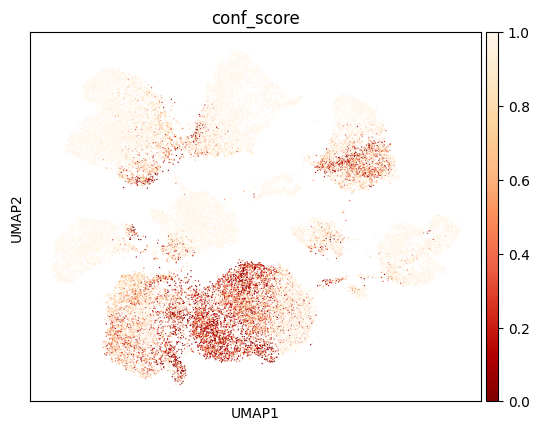

In [81]:
sc.pl.umap(p1, color = 'conf_score', cmap = 'OrRd_r',
          vmax = 1, vmin = 0)

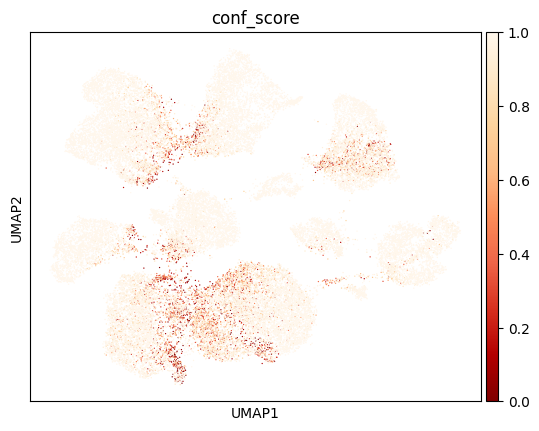

In [82]:
sc.pl.umap(p2, color = 'conf_score', cmap = 'OrRd_r',
          vmax = 1, vmin = 0)

### Label-wise comparison

In [88]:
d1 = p1.obs.groupby('label').mean()['conf_score'].to_frame().reset_index()
d2 = p2.obs.groupby('label').mean()['conf_score'].to_frame().reset_index()

d1['model'] = 'reference'
d2['model'] = 'plus-one'

In [91]:
df = pd.concat([d1,d2])

In [98]:
order1 = d1.sort_values("conf_score")['label'].values

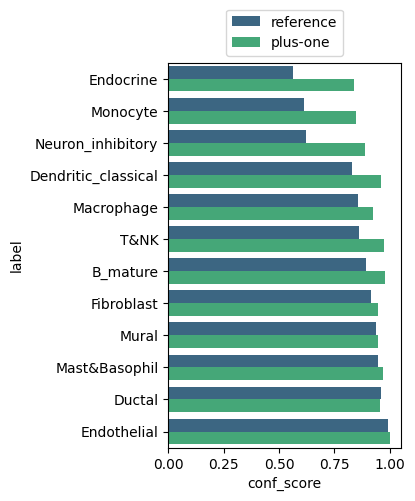

In [108]:
sns.barplot(data = df, y = 'label', hue = 'model', x = 'conf_score', order = order1,
           palette = 'viridis')
plt.gcf().set_size_inches(3,5)
plt.legend(bbox_to_anchor = (.5, 1), loc = 'lower center')

The plus-one model should show higher confidence scores, indicating improved representation of the appended cell types.

## Summary

This vignette demonstrated how to update our reference model by incorporating a new dataset. This incremental update strategy allows flexible, modular expansion of reference models and provides a practical, efficient way to expand the reference model as new tissues or conditions become available.

## Package versions

In [109]:
sc.logging.print_header()

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.22.4 scipy==1.10.1 pandas==1.5.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.11


In [110]:
pip freeze

absl-py==1.4.0
adjustText==1.2.0
aiohttp==3.8.5
aiosignal==1.3.1
anndata==0.9.2
annotated-types==0.5.0
annoy==1.17.3
anyio==3.7.1
arrow==1.2.3
astroid==2.15.8
asttokens==2.2.1
async-timeout==4.0.2
attrs==23.1.0
backcall==0.2.0
backoff==2.2.1
batchglm==0.7.4
bbknn==1.6.0
beautifulsoup4==4.12.2
blessed==1.20.0
cachetools==5.3.1
cell2location==0.1.3
celltypist==1.6.3
certifi==2024.8.30
charset-normalizer==3.4.0
chex==0.1.7
circlify==0.15.0
click==8.1.7
cloudpickle==2.2.1
cmake==3.27.0
comm==0.1.3
contextlib2==21.6.0
contourpy==1.2.0
croniter==1.4.1
cycler==0.11.0
Cython==3.0.0
dask==2023.7.0
datacache==1.4.1
DateTime==5.2
dateutils==0.6.12
debugpy==1.6.7
decorator==5.1.1
deepdiff==6.3.1
Deprecated==1.2.14
diffxpy==0.7.4
dm-tree==0.1.8
docrep==0.3.2
et_xmlfile==2.0.0
etils==1.4.0
exceptiongroup==1.1.2
executing==1.2.0
fastapi==0.100.1
fastjsonschema==2.19.1
fbpca==1.0
filelock==3.12.2
fire==0.5.0
flax==0.7.0
fonttools==4.39.4
frozenlist==1.4.0
fsspec==2023.6.0
geosketch==1.2
get-annotation